# DEEP HAPPINESS DETECTOR


Aim is to make a single prediction model to distinguish between happy and sad. <br>
The dataset will include a subset of folder including: <br>
Training: <br>
* 7164 pictures labeld as happy <br>
* 4938 pictures labeld as sad <br>
<br>
* 1825 pictures labeld as happy <br>
* 1139 pictures labeld as sad <br>

Observation: class are imbalanced. Bias for 'happy' expected.

# 0. import dependancies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Install the latest version of Tensorflow (as of 17/9/2022)

In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.6.4
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: absl-py, astunparse, clang, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, numpy, opt-einsum, protobuf, six, tensorboard, tensorflow-estimator, termcolor, typing-extensions, wheel, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-decision-forests, tensorflow-io, tensorflow-serving-api, tensorflow-transform, tfx-bsl, witwidget


# 1. TF Data pipeline

In [3]:
train_path = '../input/face-expression-recognition-dataset/images/train'
valid_path = '../input/face-expression-recognition-dataset/images/validation'

Original images are sized 48x48 pixels. The resolution is pretty bad. We can up-sample to 256x256 by uploading the data with<br>
tf.keras.utils.image_from_directory(directory)

In [4]:
TRAIN = tf.keras.utils.image_dataset_from_directory(train_path)    
VALID = tf.keras.utils.image_dataset_from_directory(valid_path)    
print(TRAIN)

Found 28821 files belonging to 7 classes.


2022-09-19 13:32:45.210859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-19 13:32:45.305403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-19 13:32:45.306209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-19 13:32:45.308232: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 7066 files belonging to 7 classes.
<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


## 1.1 dataset filtering
I am going to unbatch the Dataset to drop all classes except 'happy' and 'sad'

In [5]:
TRAIN_unbatched = TRAIN.unbatch()
VALID_unbatched = VALID.unbatch()

In [6]:
def drop_extra_classes(x,y):
    if y == 3: return True
    if y == 5: return True
    return False

train = TRAIN_unbatched.filter(drop_extra_classes)
valid = VALID_unbatched.filter(drop_extra_classes)
print(train)
print(valid)

<FilterDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>
<FilterDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>


## 1.2 Investigate the dataset

2022-09-19 13:32:49.757562: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


train input shape:  (256, 256, 3) input type:  <class 'numpy.ndarray'>
train label shape:  () label type:  <class 'numpy.int32'>
validation input shape:  (256, 256, 3) input type:  <class 'numpy.ndarray'>
validation label shape:  () label type:  <class 'numpy.int32'>


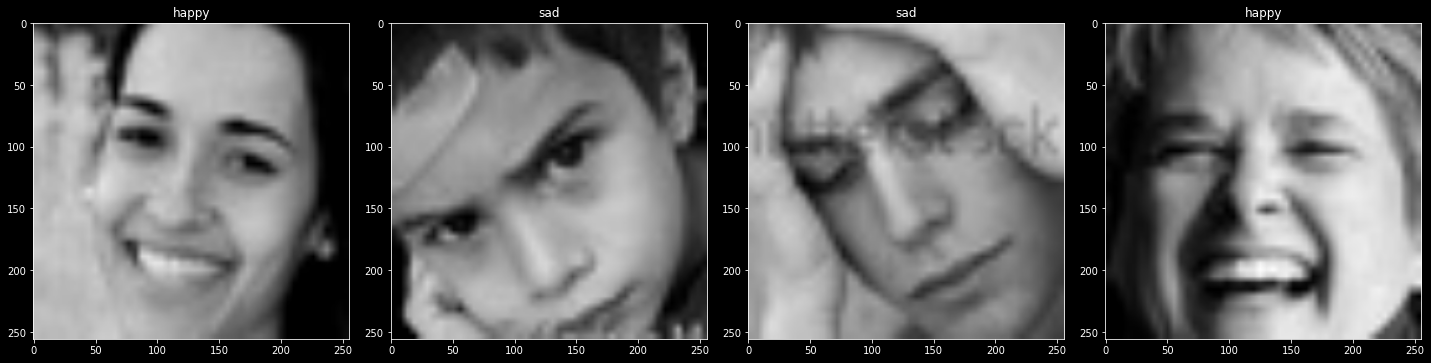

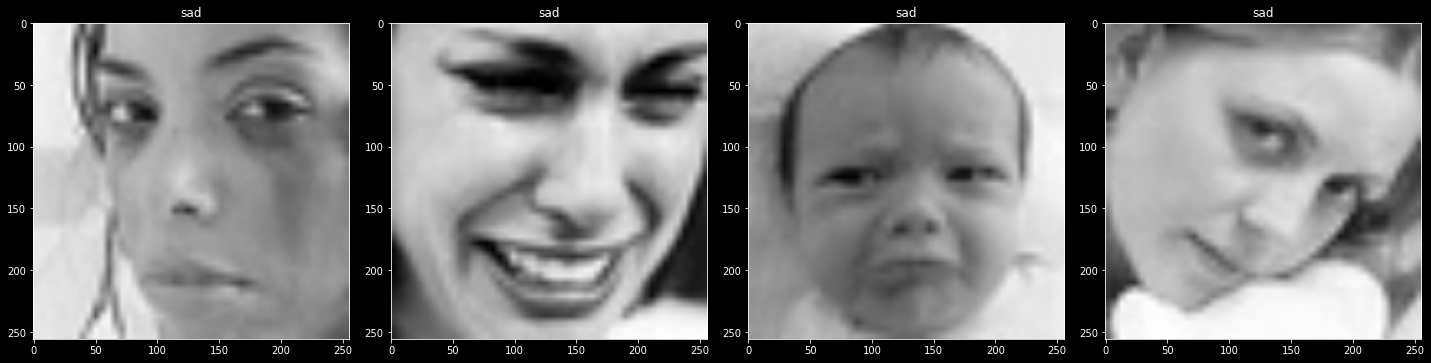

In [7]:
labels = {3:'happy', 5:'sad'}
plt.style.use('dark_background')
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for col in range(4):
    x,y = train.shuffle(buffer_size=1000).as_numpy_iterator().next()
    ax[col].imshow(x.astype(int))
    ax[col].set_title(labels[y])
print('train input shape: ',x.shape, 'input type: ',type(x))
print('train label shape: ',y.shape, 'label type: ',type(y))
plt.tight_layout()

labels = {3:'happy', 5:'sad'}
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for col in range(4):
    x,y = valid.shuffle(buffer_size=1000).as_numpy_iterator().next()
    ax[col].imshow(x.astype(int))
    ax[col].set_title(labels[y])
plt.tight_layout()
print('validation input shape: ',x.shape, 'input type: ',type(x))
print('validation label shape: ',y.shape, 'label type: ',type(y))

## 1.3 Preprocess the data

Normalizing...

In [8]:
train = train.map(lambda x,y: (x/255,y))
valid = valid.map(lambda x,y: (x/255,y))
x,y = train.as_numpy_iterator().next()


setting labels to 0-1...

In [9]:
def rename_labl(x,y):
    label = np.int32(-1)
    if y==3: label = np.int32(1)
    if y==5: label = np.int32(0)    
    return x,label

In [10]:
train = train.map(rename_labl)
valid = valid.map(rename_labl)
for i in range(10):
    x,y = train.as_numpy_iterator().next()
    print(y, end=' ')

0 0 0 1 1 0 1 0 0 1 

In [11]:
print('train input shape: ',x.shape, 'input type: ',type(x))
print('train label shape: ',y.shape, 'label type: ',type(y))

train input shape:  (256, 256, 3) input type:  <class 'numpy.ndarray'>
train label shape:  () label type:  <class 'numpy.int32'>


batching back up again 

In [12]:
train = train.batch(batch_size = 50)
valid = valid.batch(batch_size = 50)

clearing up space

In [13]:
import gc
del TRAIN, TRAIN_unbatched, VALID, VALID_unbatched
gc.collect()

11474

## 2. Model Definition

In [14]:
# Importing Deep Learning Libraries
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D,Input
from keras.models import Model,Sequential 
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

model = Sequential()

#1st CNN layer
model.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#3rd CNN layer
model.add(Conv2D(128,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Fully connected 2st layer
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 127, 127, 128)     5

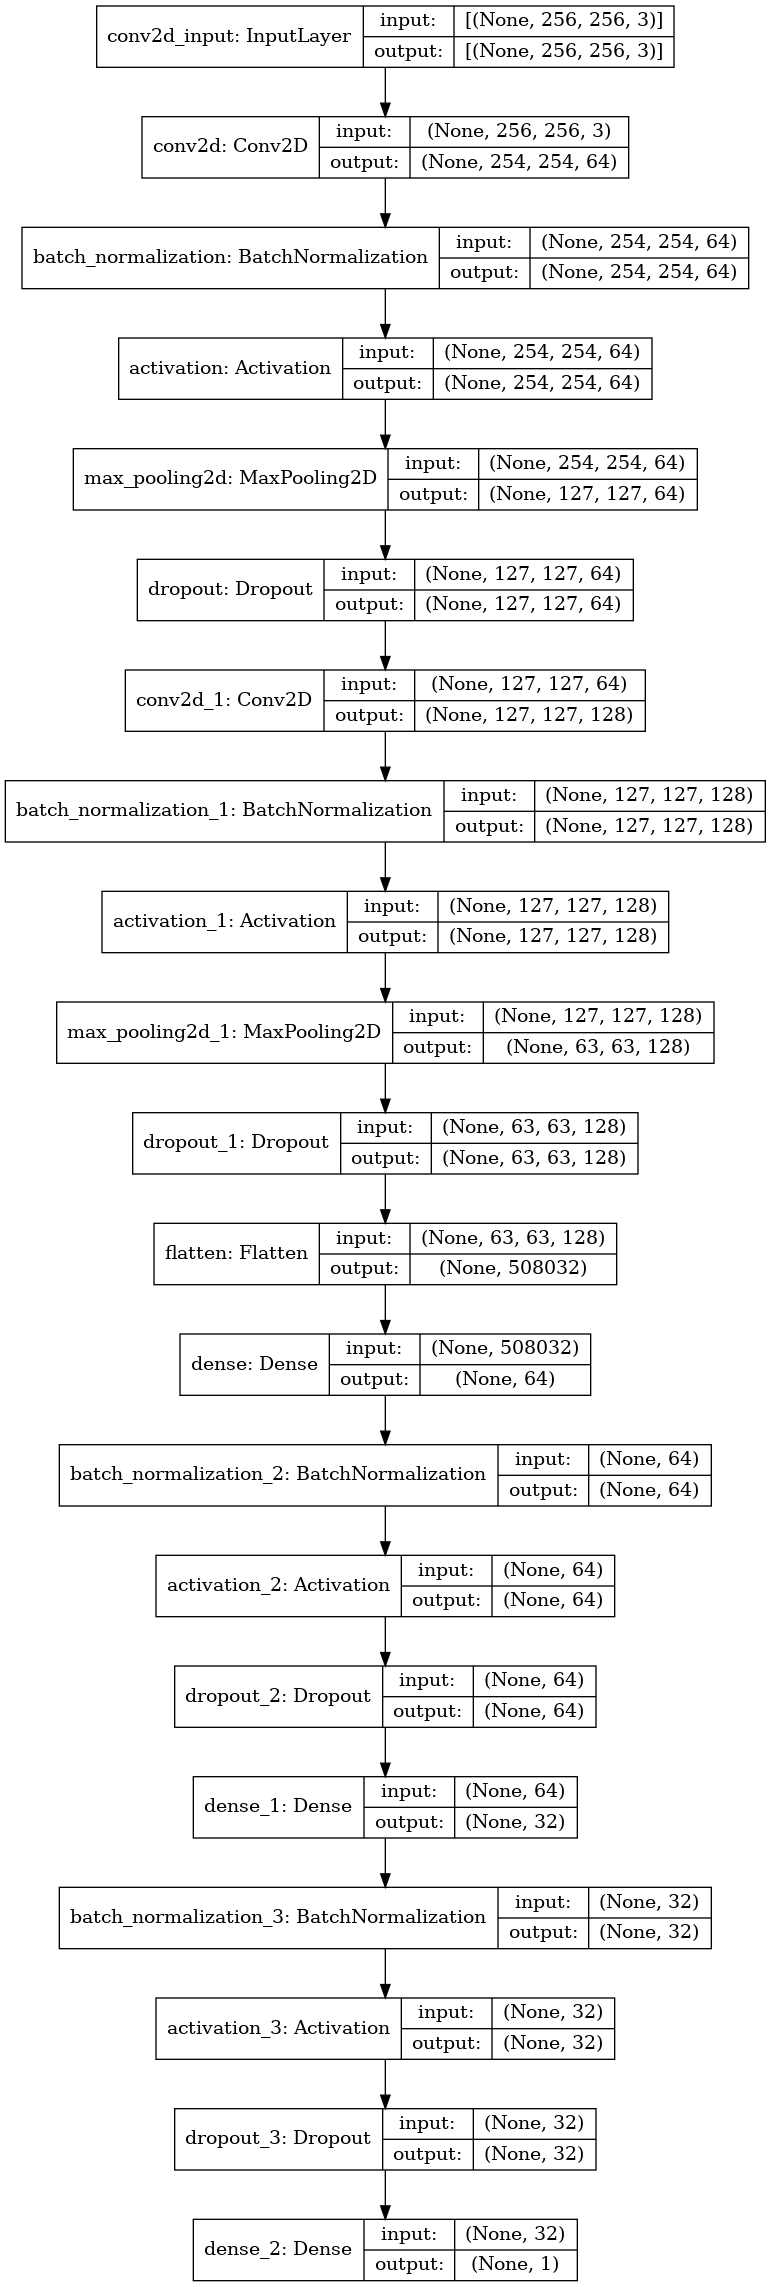

In [16]:
# Visualize and download model structure
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

2022-09-19 13:33:34.014689: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-19 13:33:34.014736: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-19 13:33:34.016755: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-09-19 13:33:34.208328: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-19 13:33:34.208507: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


## 3. Model training

In [18]:
hist = model.fit(train, epochs=50, validation_data=valid, callbacks=[tensorboard_callback,reduce_learningrate, early_stopping])

Epoch 1/50


2022-09-19 13:33:36.803648: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


      1/Unknown - 9s 9s/step - loss: 1.0503 - accuracy: 0.4200

2022-09-19 13:33:43.075759: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-19 13:33:43.075821: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


      2/Unknown - 9s 472ms/step - loss: 0.8968 - accuracy: 0.4300

2022-09-19 13:33:43.527056: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-19 13:33:43.528548: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-09-19 13:33:43.661575: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 275 callback api events and 272 activity events. 
2022-09-19 13:33:43.674049: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-19 13:33:43.698826: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_09_19_13_33_43

2022-09-19 13:33:43.713581: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_09_19_13_33_43/3ba16d73495f.trace.json.gz


      3/Unknown - 9s 414ms/step - loss: 0.8441 - accuracy: 0.4667

2022-09-19 13:33:43.739218: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_09_19_13_33_43

2022-09-19 13:33:43.742309: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_09_19_13_33_43/3ba16d73495f.memory_profile.json.gz
2022-09-19 13:33:43.743276: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/train/plugins/profile/2022_09_19_13_33_43
Dumped tool data for xplane.pb to logs/train/plugins/profile/2022_09_19_13_33_43/3ba16d73495f.xplane.pb
Dumped tool data for overview_page.pb to logs/train/plugins/profile/2022_09_19_13_33_43/3ba16d73495f.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/train/plugins/profile/2022_09_19_13_33_43/3ba16d73495f.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to logs/train/plugins/profile/2022_09_19_13_33_43/3ba16d73495f.tensorflow_stats.

243/243 [==============================] - 94s 355ms/step - loss: 0.6967 - accuracy: 0.5925 - val_loss: 0.6203 - val_accuracy: 0.6225
Epoch 2/50
243/243 [==============================] - 52s 211ms/step - loss: 0.6021 - accuracy: 0.6617 - val_loss: 0.6061 - val_accuracy: 0.6444
Epoch 3/50
243/243 [==============================] - 50s 204ms/step - loss: 0.5601 - accuracy: 0.7023 - val_loss: 0.5620 - val_accuracy: 0.6866
Epoch 4/50
243/243 [==============================] - 51s 207ms/step - loss: 0.5306 - accuracy: 0.7264 - val_loss: 0.5376 - val_accuracy: 0.7085
Epoch 5/50
243/243 [==============================] - 50s 206ms/step - loss: 0.4998 - accuracy: 0.7514 - val_loss: 0.7683 - val_accuracy: 0.6393
Epoch 6/50
243/243 [==============================] - 49s 201ms/step - loss: 0.4683 - accuracy: 0.7727 - val_loss: 0.5186 - val_accuracy: 0.7345
Epoch 7/50
243/243 [==============================] - 49s 201ms/step - loss: 0.4372 - accuracy: 0.7848 - val_loss: 0.6376 - val_accuracy: 0.6

## 4. Training Report

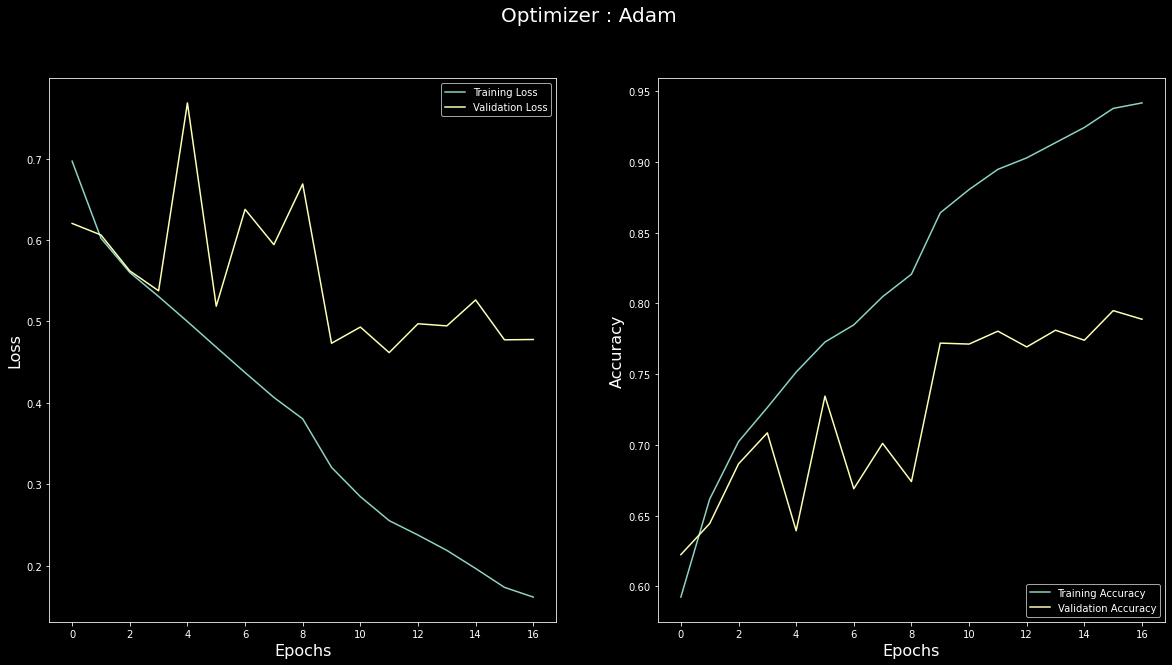

In [19]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# 5. Save model to disk

In [20]:
model.save("model3.h5")
print("Saved")

Saved
